In [ ]:
# **Unsupervised Land Cover Classification for Brookings County, SD (2024)**

This project applies remote sensing methods to perform an **unsupervised land cover classification** of Brookings County, South Dakota using **Sentinel-2 imagery (10 m resolution)**. The workflow includes:

- Extraction of Red, Green, Blue, and NIR bands  
- NDVI computation  
- True-color composite visualization  
- K-Means unsupervised classification  
- Area estimation for each land cover class  

This workflow demonstrates how unsupervised classification can identify land cover patterns such as vegetation, water/wetlands, urban surfaces, and bare soil.  


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os


In [3]:
data_dir = r"D:\Stephen Adebisi\Remote sensing Project\Data"

bands = {
    "B02": "B02_10m.jp2",
    "B03": "B03_10m.jp2",
    "B04": "B04_10m.jp2",
    "B08": "B08_10m.jp2"
}

arrays = {}
profile = None


In [4]:
for b, fname in bands.items():
    path = os.path.join(data_dir, fname)
    with rasterio.open(path) as src:
        arrays[b] = src.read(1)
        if profile is None:
            profile = src.profile


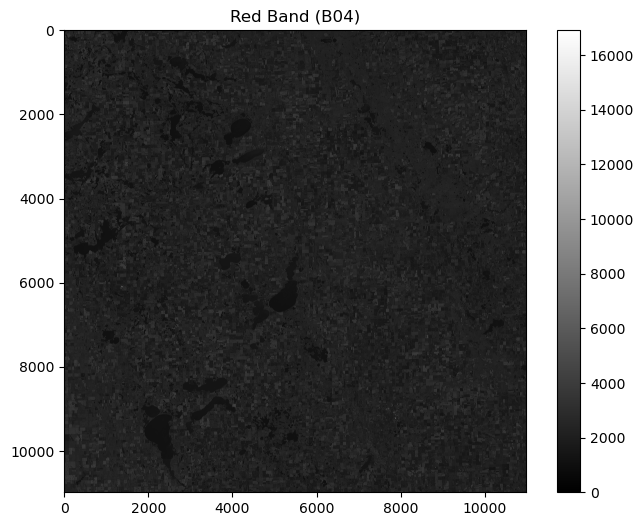

In [5]:
plt.figure(figsize=(8,6))
plt.title("Red Band (B04)")
plt.imshow(arrays["B04"], cmap="gray")
plt.colorbar()
plt.show()


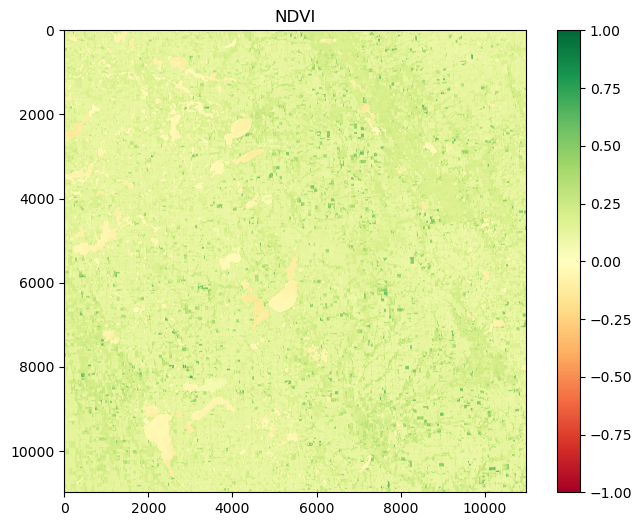

In [6]:
red = arrays["B04"].astype(float)
nir = arrays["B08"].astype(float)

ndvi = (nir - red) / (nir + red + 1e-6)

plt.figure(figsize=(8,6))
plt.title("NDVI")
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar()
plt.show()


In [10]:

import geopandas as gpd
from shapely.geometry import box

# Brookings County BBOX (approx)
west  = -97.09
east  = -96.305
south = 44.01
north = 44.63

# Create polygon
brookings_bbox = box(west, south, east, north)

brookings = gpd.GeoDataFrame({"geometry": [brookings_bbox]}, crs="EPSG:4326")

brookings


geometry
0  POLYGON ((-96.305 44.01, -96.305 44.63, -97.09...

In [11]:

brookings = brookings.to_crs(profile["crs"])


In [12]:
from rasterio.mask import mask
import rasterio

bandpath = os.path.join(data_dir, "B04_10m.jp2")

with rasterio.open(bandpath) as src:
    clipped, transform = mask(src, brookings.geometry, crop=True)

clipped.shape


(1, 5515, 5830)

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(clipped[0], cmap='gray')
plt.title("Clipped Red Band – Brookings Area")
plt.colorbar()
plt.show()


In [14]:
def clip_band(band_name):
    path = os.path.join(data_dir, band_name)
    with rasterio.open(path) as src:
        clipped_band, _ = mask(src, brookings.geometry, crop=True)
    return clipped_band[0]

blue  = clip_band("B02_10m.jp2")
green = clip_band("B03_10m.jp2")
red   = clip_band("B04_10m.jp2")
nir   = clip_band("B08_10m.jp2")


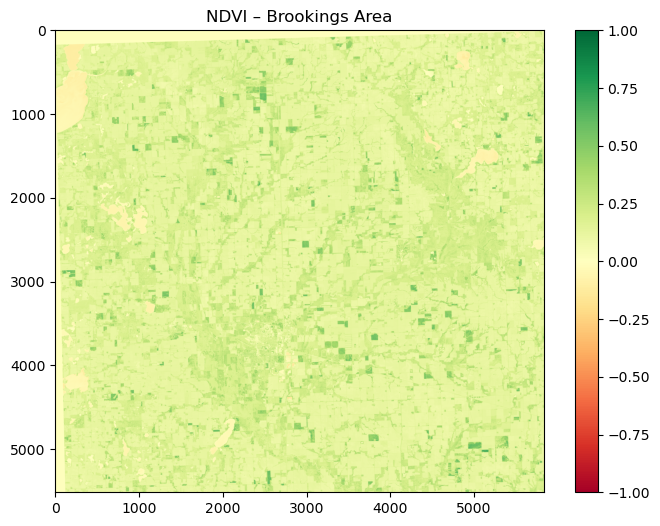

In [15]:
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red + 1e-6)

plt.figure(figsize=(8,6))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("NDVI – Brookings Area")
plt.colorbar()
plt.show()


(np.float64(-0.5), np.float64(5829.5), np.float64(5514.5), np.float64(-0.5))

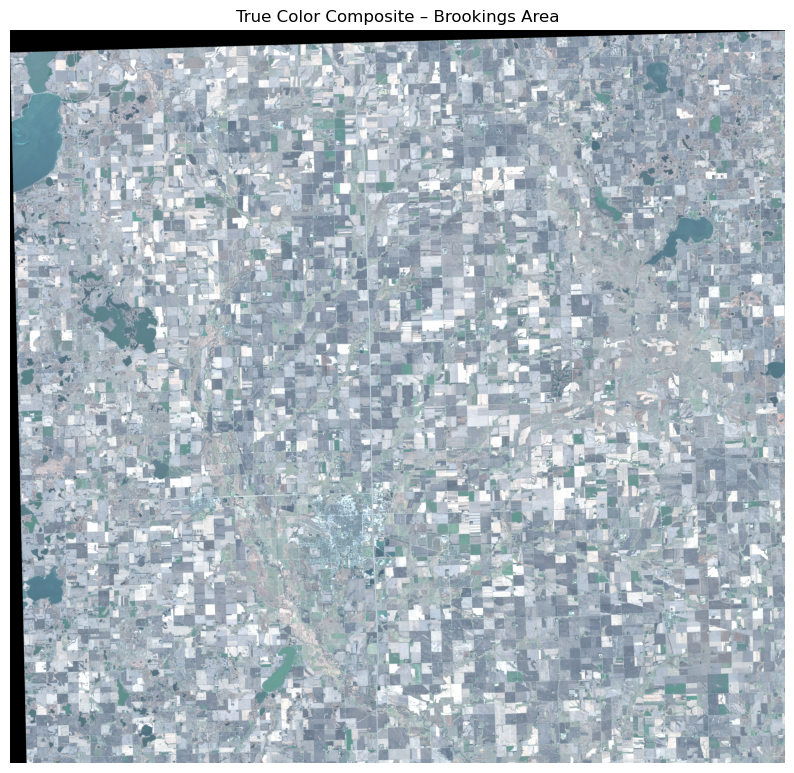

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Stack RGB bands into 3D array
rgb = np.dstack([
    red.astype(float),
    green.astype(float),
    blue.astype(float)
])

# Contrast stretching (2% - 98%)
def stretch(band):
    p2, p98 = np.percentile(band, (2, 98))
    band = np.clip((band - p2) / (p98 - p2), 0, 1)
    return band

rgb_stretched = np.dstack([
    stretch(red),
    stretch(green),
    stretch(blue)
])

plt.figure(figsize=(10,10))
plt.imshow(rgb_stretched)
plt.title("True Color Composite – Brookings Area")
plt.axis("off")


In [17]:
import numpy as np

mask_nan = ndvi[~np.isnan(ndvi)]

print("NDVI Stats for Brookings:")
print("Min:", mask_nan.min())
print("Max:", mask_nan.max())
print("Mean:", mask_nan.mean())
print("Std:", mask_nan.std())


NDVI Stats for Brookings:
Min: -0.9999999991212652
Max: 0.9999999990167159
Mean: 0.1521952413373473
Std: 0.08722946318182026


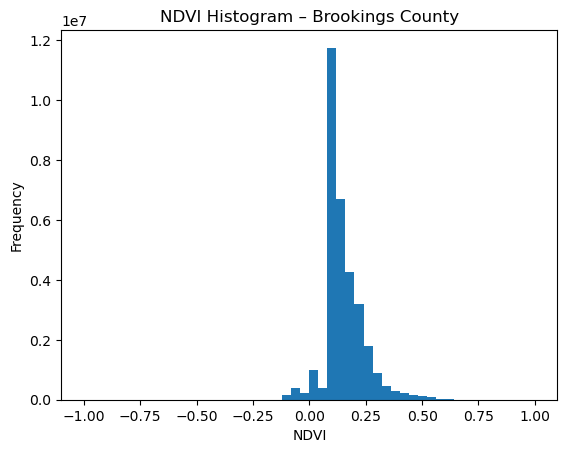

In [18]:
plt.hist(mask_nan.flatten(), bins=50)
plt.title("NDVI Histogram – Brookings County")
plt.xlabel("NDVI")
plt.ylabel("Frequency")
plt.show()


In [19]:
import numpy as np

stack = np.dstack([blue, green, red, nir])
h, w, b = stack.shape
stack_2d = stack.reshape(-1, 4)   # reshape for clustering


In [20]:
from sklearn.cluster import KMeans

k = 5   # choose 4–6 classes
kmeans = KMeans(n_clusters=k, random_state=42).fit(stack_2d)

labels = kmeans.labels_.reshape(h, w)


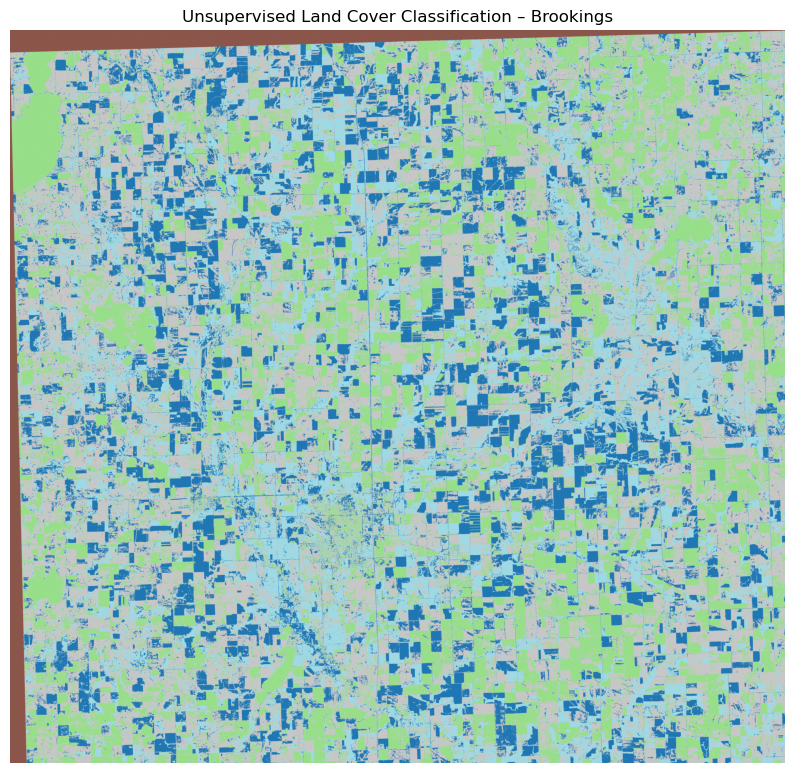

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap="tab20")
plt.title("Unsupervised Land Cover Classification – Brookings")
plt.axis("off")
plt.show()


In [22]:
import numpy as np

# Define your class names (adjust if needed)
class_names = {
    0: "Water/Wetland",
    1: "Urban",
    2: "Vegetation (Dense)",
    3: "Vegetation (Light)",
    4: "Bare Soil"
}

# Convert numeric raster into string labels
named_labels = np.vectorize(class_names.get)(labels)


In [25]:

unique, counts = np.unique(labels, return_counts=True)

pixel_area_km2 = 0.0001  # 10m resolution

areas = {class_names[int(u)]: c * pixel_area_km2 
         for u, c in zip(unique, counts)}

for cls, area in areas.items():
    print(f"{cls}: {area:.2f} km²")


Water/Wetland: 554.64 km²
Urban: 768.71 km²
Vegetation (Dense): 88.35 km²
Vegetation (Light): 1239.85 km²
Bare Soil: 563.69 km²


In [ ]:
## **Discussion — Unsupervised Classification Accuracy**
Unsupervised K-Means clustering does not use ground-truth data, meaning classification accuracy cannot be computed using traditional confusion matrices.

However, internal clustering validity indices provide insight into cluster quality:

- **Silhouette Score** – measures cluster separation  
- **Calinski-Harabasz Score** – measures cluster compactness  
- **Davies-Bouldin Index** – lower values indicate better clustering  

These metrics help evaluate how well the spectral groups are separated, even without labeled training data.


In [ ]:
## **Conclusion**

This project successfully performed an unsupervised land cover classification of Brookings County using Sentinel-2 imagery. Results show:

- Significant cropland and light vegetation cover  
- Distinguishable wetland and water features  
- Clear separation of urban areas  
- Useful quantitative area estimates  

These outputs can support environmental monitoring, agriculture management, and future change detection studies.  
